![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score




In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [3]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


<h1>1. Revisión general de las variables</h1>

<h2>Completitud</h2>

Datos completos al 100%

Resultados:
   Columna  Espacios en Blanco  NaN  % Faltantes
0    Price                   0    0          0.0
1     Year                   0    0          0.0
2  Mileage                   0    0          0.0
3    State                   0    0          0.0
4     Make                   0    0          0.0
5    Model                   0    0          0.0


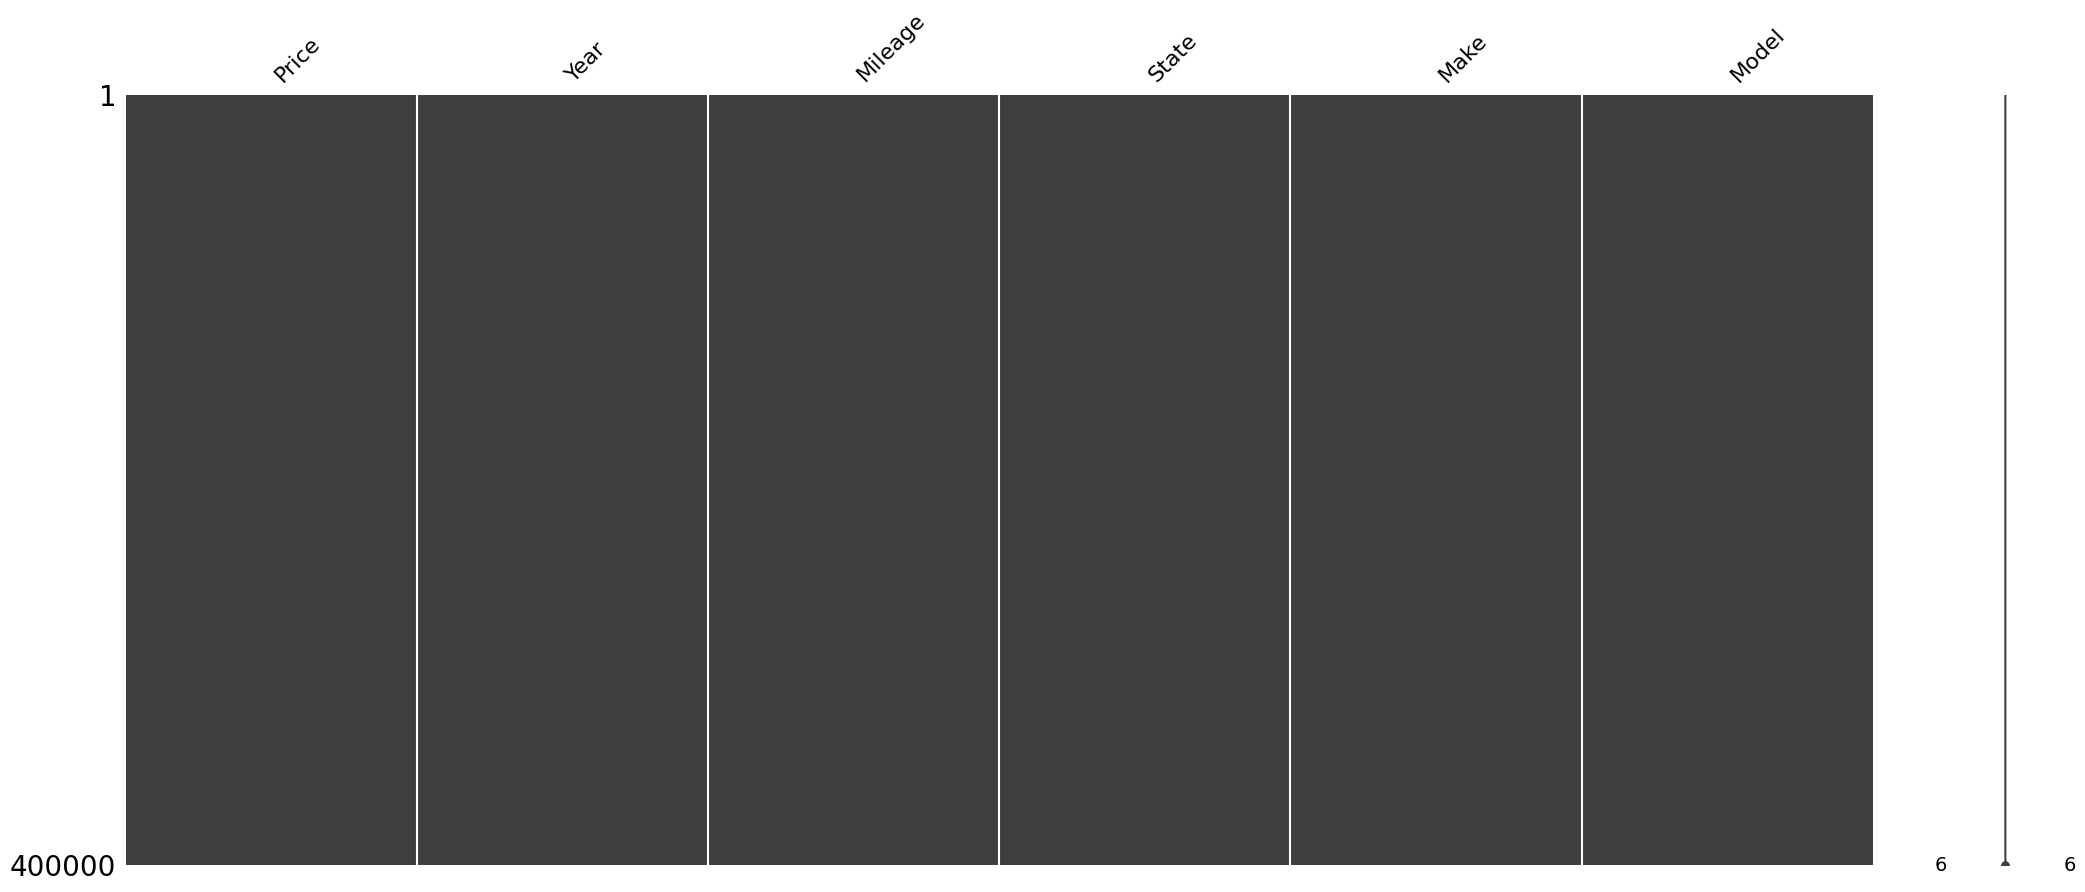

In [7]:
# Completitud de los datos
def analisis_datos(df):
    columnas = []
    espacios_blanco = []
    nan_counts = []
    porcentaje_faltantes = []

    for columna in df.columns:
        espacios_blanco.append(sum(df[columna].apply(lambda x: isinstance(x, str) and x.isspace())))
        nan_counts.append(df[columna].isna().sum())
        porcentaje_faltantes.append((df[columna].isna().sum() + espacios_blanco[-1]) / len(df) * 100)  # Calcula el porcentaje de datos faltantes
        columnas.append(columna)

    resultados_df = pd.DataFrame({
        'Columna': columnas,
        'Espacios en Blanco': espacios_blanco,
        'NaN': nan_counts,
        '% Faltantes': porcentaje_faltantes  # Agrega la columna de porcentaje de datos faltantes
    })

    print("Resultados:")
    print(resultados_df)

    msno.matrix(df)

analisis_datos(dataTraining)

<h1>2. Descripcion de variables</h1>

<h2>Variables Numericas</h2>

In [8]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


<h2>Variables categoricas</h2>

En total se tienen 3 columnas

<table>
  <tr>
    <th>Columnas</th>
    <th># Valores Unicos</th>
  </tr>
  <tr>
    <td>State</td>
    <td>51</td>
  </tr>
  <tr>
    <td>Make</td>
    <td>38</td>
  </tr>
  <tr>
    <td>Model</td>
    <td>525</td>
  </tr>
</table>

Hay un problema y es una alta cantidad de valores unicos.
una propuesta puede ser armar modelos para cada marca ya que tiene un sentido logico

In [9]:
col_numericas=['Year','Mileage']
col_categoricas=['State','Make','Model']
for col in col_categoricas:
  print(f'valores unicos de {col}:{dataTraining[col].unique()}',f'total variables: {len(dataTraining[col].unique())}', '\n')

valores unicos de State:[' FL' ' OH' ' TX' ' CO' ' ME' ' WA' ' CT' ' CA' ' LA' ' NY' ' PA' ' SC'
 ' ND' ' NC' ' GA' ' AZ' ' TN' ' KY' ' NJ' ' UT' ' IA' ' AL' ' NE' ' IL'
 ' OK' ' MD' ' NV' ' WV' ' MI' ' VA' ' WI' ' MA' ' OR' ' IN' ' NM' ' MO'
 ' HI' ' KS' ' AR' ' MN' ' MS' ' MT' ' AK' ' VT' ' SD' ' NH' ' DE' ' ID'
 ' RI' ' WY' ' DC'] total variables: 51 

valores unicos de Make:['Jeep' 'Chevrolet' 'BMW' 'Cadillac' 'Mercedes-Benz' 'Toyota' 'Buick'
 'Dodge' 'Volkswagen' 'GMC' 'Ford' 'Hyundai' 'Mitsubishi' 'Honda' 'Nissan'
 'Mazda' 'Volvo' 'Kia' 'Subaru' 'Chrysler' 'INFINITI' 'Land' 'Porsche'
 'Lexus' 'MINI' 'Lincoln' 'Audi' 'Ram' 'Mercury' 'Tesla' 'FIAT' 'Acura'
 'Scion' 'Pontiac' 'Jaguar' 'Bentley' 'Suzuki' 'Freightliner'] total variables: 38 

valores unicos de Model:['Wrangler' 'Tahoe4WD' 'X5AWD' 'SRXLuxury' '3' 'C-ClassC300' 'CamryL'
 'TacomaPreRunner' 'LaCrosse4dr' 'ChargerSXT' 'CamryLE' 'Jetta'
 'AcadiaFWD' 'EscapeSE' 'SonataLimited' 'Santa' 'Outlander' 'CruzeSedan'
 'Civic' 'Corol

<Axes: xlabel='Make'>

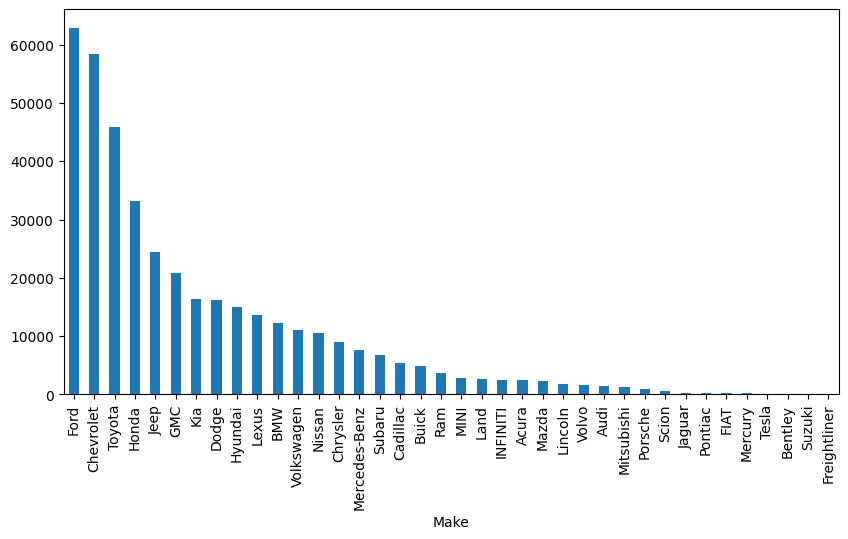

In [10]:
#Cantidad de muestras por Marca
dataTraining['Make'].value_counts().plot(kind='bar',figsize=(10,5))
# dataTraining[dataTraining['Make']=='Ford']['Model'].value_counts().plot(kind='bar',figsize=(10,5))

Debido a la naturaleza de los datos se tienen varias hipoptesis.
- Usar un unico modelo entrenado para predecir precios
- Usar 36 modelos distintos para cada marca de vehiculo

Cada uno tiene sus retos y transoformaciones
- Agrupacion de variables
- Que modelo usar
- Seleccion de hiperparametros

<h1>3. Modelamiento</h1>

<h2>Procesamiento de variables X y</h2>
se separarán los datos en modelo XTrain y yTrain, ademas se codifican variables categoricas por medio de etiquetas

In [4]:
numeric_cols = ['Price','Year', 'Mileage']
categorical_cols = ['State', 'Make', 'Model']


In [7]:
def encoder(categorical_cols):
  np.random.seed(420)
  label_encoders = {}
  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    dataTraining_copy[col] = label_encoders[col].fit_transform(dataTraining_copy[col])
    dataTesting_copy[col] = label_encoders[col].transform(dataTesting_copy[col])

#Instancio DF Training
dataTraining_copy = dataTraining.copy()
dataTraining_copy['Gama']=dataTraining_copy['Price'].apply(lambda x:0 if x<=26999 else 1)

#Instancio DF Testing
dataTesting_copy=dataTesting.copy()
dataTesting_copy['Gama']=0

#Traigo los valores 'Gama' de los datos de entrenamiento
encoder(categorical_cols)
dataTesting_copy_coded=dataTesting_copy.to_numpy()
for i in dataTesting_copy_coded:
  i[5]=round(dataTraining_copy[(dataTraining_copy['Make']==i[3])&(dataTraining_copy['Model']==i[4])]['Gama'].mean())
dataTesting_copy = pd.DataFrame(dataTesting_copy_coded, columns=dataTesting_copy.columns)

X=dataTraining_copy.drop(['Price'], axis=1)
y=dataTraining_copy[['Price']].values.ravel()


dataTesting_copy

,Year,Mileage,State,Make,Model,Gama
0,2014,31909,20,27,305,0
1,2017,5362,9,17,489,1
2,2014,50300,35,10,211,0
3,2004,132160,47,2,27,0
4,2015,25226,19,17,248,0
...,...,...,...,...,...,...
99995,2015,82719,43,12,401,0
99996,2015,19711,44,2,27,0
99997,2016,48049,4,27,305,0
99998,2017,15306,5,17,343,0


<h3>Prediccion con regresion lineal basado en un todo general</h3>

En este caso sabemos que Random Forest nos entrega el mejor resultado

Resultado: 0.7257063890237418 5631.977714271869
Resultado: 0.8426736909778206 4265.239247592866
Resultado: 0.9052833202247571 3309.5081707174227


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (3, 5).

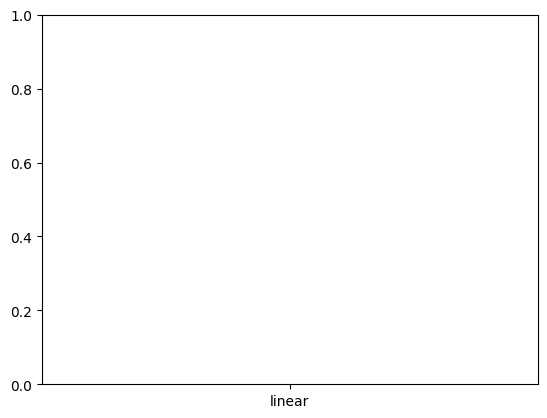

In [10]:
#Primer modelo de regresión

resultados={}

models={
    'linear':LinearRegression(),
    'decision_tree':DecisionTreeRegressor(random_state=1),
    # 'random_forest':RandomForestRegressor(random_state=1),
    # 'gradient_boosting':GradientBoostingRegressor(random_state=1),
    'XGBoost':XGBRegressor(seed=1),
    # 'neural_network':MLPRegressor(random_state=1)
}
for model,function in models.items():
    scores_r2 = cross_val_score(function, X, y, cv=5, scoring=make_scorer(r2))
    scores_rmse = cross_val_score(function, X, y, cv=5, scoring=make_scorer(rmse))
    resultados[model]=scores_r2
    print('Resultado:', scores_r2.mean(), scores_rmse.mean())

plt.bar(resultados.keys(), resultados.values())
plt.show() 

<h3>Estimador de hiper parametros</h3>

In [9]:
# Define una función para calcular el RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define una función para calcular el coeficiente de determinación (R^2)
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def best_parameters_RandomForest(estimator_range, feature_range, depth_range):
  estim_scores = []
  feat_scores = []
  depth_scores = []
  max_params = {
      'max_estimators': 0,
      'max_estimator_v': 0,
      'max_features': 0,
      'max_features_v': 0,
      'max_depth': 0,
      'max_depth_v': 0
  }

  # Modelo inicial
  clf = RandomForestRegressor(random_state=1)
  # print('Modelo inicial:', pd.Series(cross_val_score(clf, X, y, cv=10)).describe())}
  clf.fit(X, y)
  print('Modelo inicial:', clf.score(X,y))
  
  # Prueba de parámetros
  for max_depth in depth_range:
    for max_features in feature_range:
      for n_estimators in estimator_range:
        print('Entrenando con:', max_depth, max_features,n_estimators)
        clf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=1, n_jobs=-1)
        # cv_score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
        clf.fit(X, y)
        cv_score=clf.score(X,y)

        if cv_score > max_params['max_depth_v']:
          max_params['max_depth_v'] = cv_score
          max_params['max_depth'] = max_depth
          max_params['max_features_v'] = cv_score
          max_params['max_features'] = max_features
          max_params['max_estimator_v'] = cv_score
          max_params['max_estimators'] = n_estimators

        estim_scores.append((n_estimators, cv_score))
        feat_scores.append((max_features, cv_score))
        depth_scores.append((max_depth, cv_score))

  # Print the best params
  print('Mejores parámetros:', max_params)

  return estim_scores, feat_scores, depth_scores, max_params

def best_parameters_XGBoost(estimator_range, depth_range, learning_rate_range, subsample_range, colsample_bytree_range,X,y):
  estim_scores = []
  depth_scores = []
  learning_rate_scores = []
  subsample_scores = []
  colsample_bytree_scores = []

  # Modelo inicial
  clf = XGBRegressor(seed=1)
  scores_r2 = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(r2))
  scores_rmse = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(rmse))
  print('Modelo inicial:', scores_r2.mean(), scores_rmse.mean())
  max_params = {
    'r2_score': 0,
    'rmse':100000,
    'max_estimators': 0,
    'max_depth': 0,
    'max_learning_rate': 0,
    'max_subsample': 0,
    'max_colsample_bytree': 0,
  }
  
  # Prueba de parámetros
  for max_depth in depth_range:
    for n_estimators in estimator_range:
      for learning_rate in learning_rate_range:
        for subsample in subsample_range:
          for colsample_bytree in colsample_bytree_range:
            print('Entrenando con: ',max_depth,n_estimators,learning_rate,subsample,colsample_bytree)
            clf = XGBRegressor(n_estimators=n_estimators, 
              max_depth=max_depth, 
              learning_rate=learning_rate,
              subsample=subsample,
              colsample_bytree=colsample_bytree,
              seed=1)
            scores_r2 = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(r2))
            scores_rmse = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(rmse))
            print('Resultado:', scores_r2.mean(), scores_rmse.mean())

            if scores_rmse.mean() < max_params['rmse']:
              max_params['rmse'] = scores_rmse.mean()
              max_params['r2_score'] = scores_r2.mean()
              max_params['max_depth'] = max_depth
              max_params['max_estimators'] = n_estimators
              max_params['max_learning_rate'] = learning_rate
              max_params['max_subsample'] = subsample
              max_params['max_colsample_bytree'] = colsample_bytree

            estim_scores.append((n_estimators, scores_rmse.mean()))
            depth_scores.append((max_depth, scores_rmse.mean()))
            learning_rate_scores.append((learning_rate, scores_rmse.mean()))
            subsample_scores.append((subsample, scores_rmse.mean()))
            colsample_bytree_scores.append((colsample_bytree, scores_rmse.mean()))

  # Print the best params
  print('Mejores parámetros:', max_params)

  return max_params


<h3>Modelo XGBoost Con el modelo completo</h3>

In [221]:
depth_range = [2,5,8,10]
estimator_range = range(2000,3000, 100)
learning_rate_range = [1]
subsample_range = [1]
colsample_bytree_range = [0.5]

max_params = best_parameters_XGBoost(estimator_range, depth_range, learning_rate_range, subsample_range, colsample_bytree_range,X,y)

Modelo inicial: 0.9049288571647758 3315.6999864861114
Entrenando con:  2 2000 1 1 0.5
Resultado: 0.8787704090378888 3744.168911174056
Entrenando con:  2 2100 1 1 0.5
Resultado: 0.8792945767016203 3736.068341864945
Entrenando con:  2 2200 1 1 0.5
Resultado: 0.8797204491224253 3729.4725092443696
Entrenando con:  2 2300 1 1 0.5
Resultado: 0.8801568681214949 3722.700827365341
Entrenando con:  2 2400 1 1 0.5
Resultado: 0.8805817973829321 3716.0969536532566
Entrenando con:  2 2500 1 1 0.5
Resultado: 0.8809890129967183 3709.7565297569913
Entrenando con:  2 2600 1 1 0.5
Resultado: 0.881348367863883 3704.151959137671
Entrenando con:  2 2700 1 1 0.5
Resultado: 0.8817533424449951 3697.82619973142
Entrenando con:  2 2800 1 1 0.5
Resultado: 0.8820074847832322 3693.8517279557964
Entrenando con:  2 2900 1 1 0.5
Resultado: 0.8822617814317872 3689.868242547354
Entrenando con:  5 2000 1 1 0.5
Resultado: 0.9029788759472096 3349.550760244064
Entrenando con:  5 2100 1 1 0.5
Resultado: 0.9029497271915086 33

<h3>Prediccion con regresion lineal basado en un Marca</h3>

Debido a que hay amplia informacion, se hizo una segregacion de la data a modelar basados en marca, modelo, estado y kilometraje, se entrena un modelo XGBoost y uno a uno se muestran los resultados. Para el ejemplo dado, se ve un resultado 

In [27]:
def encoder_marca(categorical_cols):
    np.random.seed(420)
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df_marca[col] = label_encoders[col].fit_transform(df_marca[col])
        dt_marca[col] = label_encoders[col].transform(dt_marca[col])

modelo={
    'modelo_1':0,
    'modelo_2':0,
    'modelo_3':0,
    'modelo_4':0,
}
df_marca = dataTraining.copy()
dt_marca = dataTesting.copy()
dt_marca['Price']=0
encoder_marca(categorical_cols)
pricing_results=[]

for row in dt_marca.iterrows():
#Encuentro datos similares
    similares=df_marca[
        (df_marca.Make==row[1].Make)&
        (df_marca.Model==row[1].Model)&
        (df_marca.State==row[1].State)&
        (df_marca.Mileage.between(row[1].Mileage - 5000, row[1].Mileage + 5000))   
    ].sort_values(by='Mileage')
    if(similares.shape[0]==0):
        similares=df_marca[
            (df_marca.Make==row[1].Make)&
            (df_marca.Model==row[1].Model)&
            (df_marca.State==row[1].State)
        ].sort_values(by='Mileage')
        if(similares.shape[0]==0):
            similares=df_marca[
                (df_marca.Make==row[1].Make)&
                (df_marca.Model==row[1].Model)&
                (df_marca.Mileage.between(row[1].Mileage - 5000, row[1].Mileage + 5000))   
            ].sort_values(by='Mileage')
            if(similares.shape[0]==0):
                similares=df_marca[
                    (df_marca.Make==row[1].Make)&
                    (df_marca.Model==row[1].Model)
                ].sort_values(by='Mileage')
                modelo['modelo_4']+=1
            else:
                modelo['modelo_3']+=1
        else:
            modelo['modelo_2']+=1
    else:
        modelo['modelo_1']+=1
#Modelo
    X_similares=similares.drop(['Price'], axis=1)
    y_similares=similares[['Price']].values.ravel()
    model=XGBRegressor()
    model.fit(X_similares, y_similares)
#Predigo con modelo
    pred=model.predict([row[1].drop(['Price'])])
    pricing_results.append(np.round(pred[0]).astype(int))
    if pred[0]==0:
        print('ERROR: ',row[0])
    else:
        print(row[0], pred[0])


#Predigo con .mean

    # pricing_results.append(np.round(similares.Price.mean()).astype(int))
    # print(row[0])

#Genero documento
dt_marca['Price']=pricing_results
y_pred = pd.DataFrame(dt_marca, index=dt_marca.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
print('>_> (100% papa)')
modelo

0 22987.0
1 33034.117
2 22555.0
3 8494.607
4 29668.693
5 14600.002
6 12893.0
7 28915.855
8 44917.996
9 13994.999
10 17250.0
11 15479.993
12 34496.01
13 20487.994
14 39500.01
15 8352.023
16 27332.162
17 31476.193
18 12995.0
19 22000.006
20 7495.002
21 21977.006
22 15988.003
23 14900.013
24 30304.023
25 16288.0
26 24993.129
27 34855.582
28 25987.994
29 23994.998
30 17449.994
31 39869.633
32 14686.003
33 20096.734
34 21874.994
35 22995.006
36 26997.994
37 38178.387
38 43592.414
39 41187.258
40 14707.542
41 13772.001
42 29499.994
43 38918.438
44 68991.98
45 15719.333
46 26995.0
47 21799.01
48 15624.001
49 14989.003
50 12988.0
51 20977.021
52 15900.013
53 13982.304
54 25868.0
55 8700.003
56 8249.997
57 12998.0
58 12464.032
59 18435.998
60 13490.003
61 16400.064
62 20900.0
63 18946.994
64 7850.002
65 16373.293
66 17457.0
67 8697.335
68 17888.09
69 12795.0
70 15368.305
71 33685.434
72 28782.064
73 55949.992
74 11430.199
75 5995.0
76 6799.9644
77 11990.997
78 8987.997
79 15899.997
80 24771.0
8

{'modelo_1': 85934, 'modelo_2': 13214, 'modelo_3': 833, 'modelo_4': 19}

<h3>Encontrando los mejores hiperparametros</h3>

In [ ]:


# Define los rangos
depth_range = range(5,10)
feature_range = [1]  # Ajusta según tu conjunto de datos
estimator_range = range(110, 310, 10)
learning_rate_range = [1]
subsample_range = [1]
colsample_bytree_range = [0.5]

# Ejecuta la función
# max_params = best_parameters_XGBoost(estimator_range, feature_range, depth_range, learning_rate_range, subsample_range, colsample_bytree_range, XTrain_ford, yTrain_ford, XTest_ford, yTest_ford)


In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

              Price
ID                 
0      33090.508914
1      76303.572981
2      59899.545636
3      49899.386315
4      16701.398033
...             ...
99995  64422.862300
99996  63443.967139
99997  55584.005547
99998  42458.543350
99999  34243.136396

[100000 rows x 1 columns]


In [12]:
# Guardar predicciones en formato exigido en la competencia de kaggle

clf = XGBRegressor(n_estimators=2000, 
  max_depth=5, 
  learning_rate=1,
  subsample=1,
  colsample_bytree=0.5,
  seed=1
)

# clf = XGBRegressor(seed=1)
clf.fit(X,y)
pred=clf.predict(dataTesting_copy)
valor_final=np.round(pred).astype(int)
y_pred = pd.DataFrame(valor_final, index=dataTesting_copy.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()


,Price
0,20331
1,36388
2,15876
3,8416
4,25684
